In [13]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math
import random
from functools import partial
import DS._6probability as pr
import DS._5statistics as stat
import DS._4linear_algebra as la
import DS._8gradient as gr
%matplotlib inline

Exploring one Dimensional Data

In [2]:
def bucketsize(point, bucket_size):
    """floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    """buckets the points and counts how many in each bucket"""
    return Counter(bucketsize(point, bucket_size)
                   for point in points)

def plot_histogram(points, bucket_size, title=''):
    histogram = make_histogram(points, bucket_size)
    plt.bar(list(histogram.keys()), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

In [3]:
random.seed(0)

uniform = [200 * random.random() - 100 
           for _ in range(10000)]

normal = [57 * pr.inverse_normal_cdf(random.random()) 
          for _ in range(10000)]

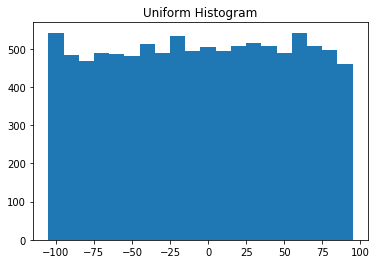

In [4]:
plot_histogram(uniform, 10, "Uniform Histogram")

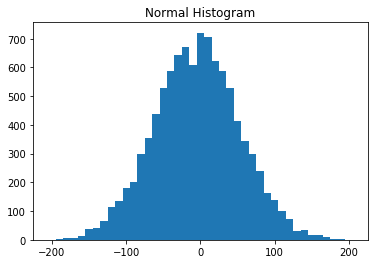

In [5]:
plot_histogram(normal, 10, "Normal Histogram")

Two dimensions

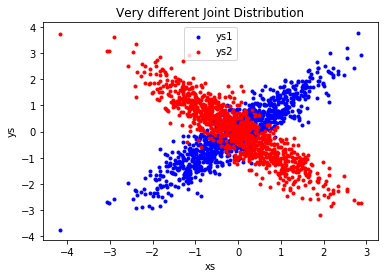

In [6]:
def random_normal():
    """returns a random draw from a standard normal distribution"""
    return pr.inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

plt.scatter(xs, ys1, marker='.', color='blue', label='ys1')
plt.scatter(xs, ys2, marker='.', color='red', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title('Very different Joint Distribution')
plt.show()

In [7]:
print(stat.correlation(xs, ys1)) #0.9
print(stat.correlation(xs, ys2)) #-0.9

0.9039746454937931
-0.8937031875818923


In [8]:
def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i,j)th entry
    is the correlation between columns i and j of data"""
    _, num_columns = la.shape(data)
    def matrix_entry(i, j):
        return stat.correlation(la.get_column(data, i), 
                                la.get_column(A,j))
    return la.make_matrix(num_columns, num_columns, matrix_entry)

Cleaning and Munging

In [ ]:
def try_or_none(f):
    def f_ro_none(x):
        try: return f(x)
        except: return None
    return f_ro_none


def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value 
            for value, parser in zip(input_row, parsers)]


def parse_rows_with(reader, parsers):
    for row in reader:
        yield parse_row(row, parsers)

In [ ]:
data = [{'closing price':102.06, 'symbol':'AAPL'},
        {'closing price':55.77, 'symbol':'ALB'}]

max_aapl_price = max(row['closing price'] 
                     for row in data if row['symbol'] == 'AAPL')

#TODO:

Rescaling

In [ ]:
def scale(data_matrix):
    """returns the means and standard deviations of each columns"""
    num_rows, num_cols = la.shape(data_matrix)
    means = [stat.mean(la.get_column(data_matrix, j)) 
             for j in range(num_cols)]
    stdevs = [stat.std_deviation(la.get_column(data_matrix, j)) 
              for j in range(num_cols)]
    return means, stdevs

def rescale(data_matrix):
    """rescales the iput data so that each column has mean 0 and std dev 1
     leaves alone columns with no deviation"""
    means, stdevs = scale(data_matrix)
    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]
    num_rows, num_cols = la.shape(data_matrix)
    return la.make_matrix(num_rows, num_cols, rescaled)

PCA

In [ ]:
def de_mean_matrix(A):
    """returns the result of subtracting from every value in A the mean value of its column.
    The resulting matrix has mean 0 in every column"""
    nr, nc = la.shape(A)
    column_means, _ = scale(A)
    return la.make_matrix(nr, nc, lambda i, j: A[i] - column_means[j])


def direction(w):
    mag = la.magnitude(w)
    return [wi / mag for wi in w]


def directional_variance_i(x_i, w):
    """the variance of the row x_i in the direction determined by w"""
    return sum([x_ii * d_i for x_ii, d_i in zip(x_i, direction(w))]) ** 2


def directional_variance(X, w):
    """the variance of the data in the direction determined by w"""
    return sum(directional_variance_i(x_i, w) for x_i in X)


def directional_variance_gradient_i(x_i, w):
    """the contribution of row_i to the gradient of the direction-w variance"""
    projection_length = sum([x_ii * d_i for x_ii, d_i in zip(x_i, direction(w))])
    return [2 * projection_length * x_ij for x_ij in x_i]


def directional_variance_gradient(X, w):
    return la.vector_sum(directional_variance_gradient_i(x_i, w) for x_i in X)


def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = gr.maximize_batch(partial(directional_variance, X), 
                                           # is now a function of w 
                                           partial(directional_variance_gradient, X),
                                           # is now a function of w
                                           guess)
    return direction(unscaled_maximizer)


def project(v, w):
    """return the projection of v onto the direction w"""
    projection_length = la.dot(v, w)
    return [projection_length * wi for wi in w]

def remove_prjection_from_vector(v, w):
    """projects v onto w and substracts the resultfrom v"""
    return la.vector_substract(v, project(v, w))


def remove_projection(X, w):
    """for each row of X projects the row onto w, and substracts the result from the row"""
    return [remove_prjection_from_vector(xi, w) for x_i in X]


def principal_component_ananlysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)
    return components


def transform_vector(v, components):
    return [la.dot(v, w) for w in components]


def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]